In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
data_dir = "gdrive/MyDrive/PROJETO/NovoDATASET2"

Mounted at /content/gdrive


In [2]:
# Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time
import copy
from skimage.metrics import structural_similarity as ssim
from skimage import transform
from skimage import io
from skimage.color import gray2rgb
import os


plt.ion()   # interactive mode

Carregar dados

In [3]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [4]:
data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.ToTensor()
    ]),
    'VAL': transforms.Compose([
        transforms.ToTensor()
    ]),
    'TEST': transforms.Compose([
        transforms.ToTensor()
    ])
}

# Carrega o conjunto de dados de imagens
image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['TRAIN', 'VAL', 'TEST']}

# Cria um DataLoader para carregar as imagens
batch_size = 1
loader = torch.utils.data.DataLoader(image_datasets['TRAIN'], batch_size=batch_size, shuffle=False)

# Calcula a média e o desvio padrão das imagens
mean = 0.
std = 0.
n_images = 0

for images, _, _ in loader:
    batch_samples = images.size(0)
    images = torch.stack(tuple(images), dim=0)
    n_images += batch_samples
    mean += images.mean([0, 2, 3]) * batch_samples
    std += images.std([0, 2, 3]) * batch_samples
mean /= n_images
std /= n_images

print('mean:', mean)
print('std:', std)

mean: tensor([0.7165, 0.6898, 0.6662])
std: tensor([0.2212, 0.2227, 0.2265])


In [5]:
# Data augmentation and normalization for training

data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'VAL': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'TEST': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['TRAIN', 'VAL', 'TEST']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['TRAIN', 'VAL', 'TEST']}

# Train 143 (56,5%), Val 62 (24,5%), Test 48 (19%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['TRAIN', 'VAL', 'TEST']}
class_names = image_datasets['TRAIN'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
caminho = 'gdrive/MyDrive/PROJETO/modelocnn.pt'
model_path = caminho
num_classes = 5

# Carregar o modelo MobileNetV2 com a última camada modificada
model = torchvision.models.mobilenet_v2(pretrained=False)
model.classifier[-1] = nn.Linear(model.last_channel, num_classes)

# Mover o modelo para o dispositivo
model = model.to(device)

# Carregar os pesos do modelo
model.load_state_dict(torch.load(model_path, map_location=device))

# Modo de avaliação
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [7]:
# Loop de teste
pred_test = []
true_labels = []

with torch.no_grad():
    for inputs, labels, _ in dataloaders['TEST']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        pred_test.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

val_accuracy = accuracy_score(pred_test, true_labels)
val_bal_accuracy = balanced_accuracy_score(pred_test, true_labels)
val_f1 = f1_score(pred_test, true_labels, average='macro')

print('Accuracy: {:.4f}'.format(val_accuracy))
print('Balanced Accuracy: {:.4f}'.format(val_bal_accuracy))
print('F1-Score: {:.4f}'.format(val_f1))




Accuracy: 0.9458
Balanced Accuracy: 0.9479
F1-Score: 0.9451


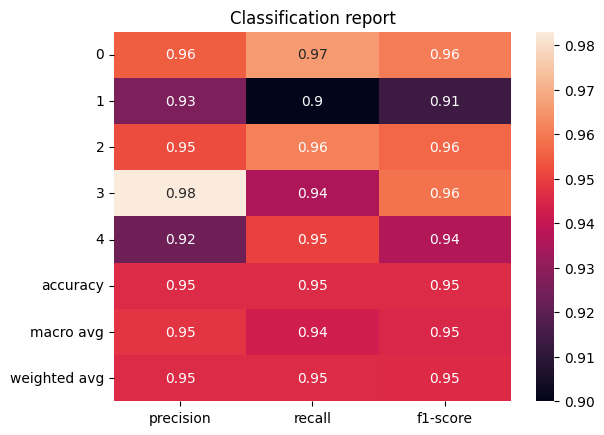

In [9]:
import seaborn as sns
import pandas as pd
classification_report = classification_report(true_labels, pred_test, zero_division=1, output_dict=True)
sns.heatmap(pd.DataFrame(classification_report).iloc[:-1, :].T, annot=True)
plt.title("Classification report")
plt.show()

In [11]:
ConfusionMatrixDisplay(confusion_mtx).plot()
plt.title("Matriz de confusão")
plt.grid(False)
plt.show()

NameError: ignored